In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms
import numpy as np
import matplotlib.pyplot as plt
import math

from collections import Counter




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]


In [3]:
def lorenz_curve(X):

    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    X_lorenz[0], X_lorenz[-1]

    fig, ax = plt.subplots(figsize=[10,10])
    ax.plot(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='red', label='income')
    ax.plot([0,1], [0,1], color='k', label='bissectrice')
    plt.vlines(x=0.71, ymin=0, ymax=0.5, color='green', linestyle='-', linewidth=1, label='Median')
    plt.hlines(xmin=0.71, xmax=0, y=0.5, color='green', linestyle='-', linewidth=1)
    plt.title("Courbe de lorenz "+i)
    plt.legend()
    plt.show()

In [5]:
def calc_anova(x,y,data):
    
    k = len(pd.unique(data[x]))  # nombre de groupes
    N = len(data.values)  # taille de l'échantillon
    n = data.groupby(x).size() # nb de valeurs par groupes
    
    # DF = Degré de liberté
    
    DFbetween = k - 1
    DFwithin = N - k
    DFtotal = N - 1

    moyenne_y = data[y].mean()

    classes = []

    for classe in data[x].unique():

        yi_classe = data[y][data[x]==classe]

        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean(),
                       'variance_classe': yi_classe.var(ddof=0)})

    SCT = sum([(yj-moyenne_y)**2 for yj in data[y]])

    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    
    SCR = sum([c['ni']*(c['variance_classe']) for c in classes])
    
    
   
    
    
    MSbetween = SCE/DFbetween
    MSwithin = SCR/DFwithin
    F_value = MSbetween/MSwithin
    p_value = st.f.sf(F_value, DFbetween, DFwithin)
    
    resultat = dict({'SCE':round(SCE,3),'SCT':round(SCT,3),'SCR':round(SCR,3),'eta_squared':round(SCE/SCT,3),'Valeur_F':F_value,'P-valeur':p_value})


    return resultat

In [6]:
data=pd.read_csv("data-projet7.csv")



In [7]:
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297
...,...,...,...,...,...,...
11594,COD,2008,96,100,"810,6233","303,19305"
11595,COD,2008,97,100,"911,7834","303,19305"
11596,COD,2008,98,100,"1057,8074","303,19305"
11597,COD,2008,99,100,"1286,6029","303,19305"


In [8]:
print( str(data.isna().sum()) + '\n')

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64



In [9]:
# Recherche des valeurs dupliquées
print('Valeurs dupliquées : ', data.duplicated().sum())

Valeurs dupliquées :  0


In [10]:
year_survey = data['year_survey'].unique()
print(np.sort(year_survey))

[2004 2006 2007 2008 2009 2010 2011]


In [11]:
#Nombre de pays recensés dans le dataset "data"
print(str(len(data['country'].unique())) + ' Pays dans notre liste de correspondance code pays / Pays')
print('et ' + str(data.duplicated().sum()) + ' doublon, les pays sont bien distincts.')

116 Pays dans notre liste de correspondance code pays / Pays
et 0 doublon, les pays sont bien distincts.


# Intégration des pays par leurs codes iso

In [12]:
#Agrégation des données selon les pays, puis application d'une fonction .nunique()
data_manquant= data.groupby('country').nunique()
data_manquant[data_manquant['quantile'] < 100]


,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
LTU,1,99,1,99,1


In [13]:
data.dtypes

country         object
year_survey      int64
quantile         int64
nb_quantiles     int64
income          object
gdpppp          object
dtype: object

In [14]:
data['income'] = data['income'].str.replace(',','.')
data['income'] =data['income'].apply(lambda x:float(x))

In [15]:
data['gdpppp'] = data['gdpppp'].str.replace(',','.')
data['gdpppp'] =data['gdpppp'].apply(lambda x:float(x))

In [16]:
ltu_41 =data.loc[(data['country'] == 'LTU') & (data['quantile'] == 40) 
                  | (data['country'] == 'LTU') & (data['quantile'] == 42)]['income'].mean()
ltu_41

4882.14065

In [17]:
#Création de la ligne manquante selon le pays 'LTU' & quantile '41'
ltu_41_row = pd.DataFrame({'country': ['LTU'], 'year_survey': [2008], 'quantile': [41], 
                           'nb_quantiles': [100], 'income': [ltu_41], 'gdpppp': 17571})
ltu_41_row


,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,LTU,2008,41,100,4882.14065,17571


In [18]:
data = pd.concat([data, ltu_41_row], ignore_index=True, sort=True)
display(data.shape)
data.head()

(11600, 6)

,country,gdpppp,income,nb_quantiles,quantile,year_survey
0,ALB,7297.0,728.89795,100,1,2008
1,ALB,7297.0,916.66235,100,2,2008
2,ALB,7297.0,1010.91600,100,3,2008
3,ALB,7297.0,1086.90780,100,4,2008
4,ALB,7297.0,1132.69970,100,5,2008


In [19]:

#l'intégration des noms de pays selon leurs codes
country_list = pd.read_csv('sql-pays.csv', header=None)
country_list.rename(columns={3:'country_code', 5:'country'}, inplace=True)
country_list = country_list.iloc[:, [3,5]]
country_list.head()

,country_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,ATA,Antarctica
3,DZA,Algeria
4,ASM,American Samoa


In [20]:
#Création d'un échantillon de travail, le dataframe "df1"
df1 = data.copy()
df1.rename(columns={'country': 'country_code', 'year_survey': 'year'}, inplace=True)
df1

,country_code,gdpppp,income,nb_quantiles,quantile,year
0,ALB,7297.00000,728.89795,100,1,2008
1,ALB,7297.00000,916.66235,100,2,2008
2,ALB,7297.00000,1010.91600,100,3,2008
3,ALB,7297.00000,1086.90780,100,4,2008
4,ALB,7297.00000,1132.69970,100,5,2008
...,...,...,...,...,...,...
11595,COD,303.19305,911.78340,100,97,2008
11596,COD,303.19305,1057.80740,100,98,2008
11597,COD,303.19305,1286.60290,100,99,2008
11598,COD,303.19305,2243.12260,100,100,2008


In [21]:
df1.country_code.unique()

array(['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BFA', 'BGD', 'BGR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAF', 'CAN', 'CHL', 'CHN',
       'CIV', 'CMR', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM',
       'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR', 'GEO',
       'GHA', 'GIN', 'GRC', 'GTM', 'HND', 'HRV', 'HUN', 'IDN', 'IND',
       'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ',
       'KEN', 'KGZ', 'KHM', 'KOR', 'XKX', 'LAO', 'LBR', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI', 'MNE',
       'MNG', 'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY',
       'ROU', 'RUS', 'SDN', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE', 'SWZ',
       'SYR', 'THA', 'TJK', 'TLS', 'TUR', 'TWN', 'TZA', 'UGA', 'UKR',
       'URY', 'USA', 'VEN', 'VNM', 'PSE', 'YEM', 'ZAF', 'COD'],
      dtype=object)

In [22]:
#Identification des pays avec différence d'intitulé entre "df1" et "country_population"
l1 = list(df1['country_code'].unique())
l2 = list(country_list['country_code'].unique())
[country for country in l1 if country not in l2]

['XKX', 'MNE', 'SRB']

In [23]:
#Intégration de ces 3 pays dans le référentiel pays "country_list"
missing = pd.DataFrame([
    ['XKX', 'Kosovo'], 
    ['MNE', 'Montenegro'],
    ['SRB', 'Serbia']], 
    columns=['country_code', 'country'])

country_list = pd.concat([country_list, missing], ignore_index=True, axis=0)
country_list.head()

,country_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,ATA,Antarctica
3,DZA,Algeria
4,ASM,American Samoa


In [24]:
df2=df1.copy()

In [25]:
#Intégration dans l'échantillon "df" des noms de pays selon leur code pays
df2 = pd.merge(df1, country_list, how='left', on='country_code')
df2 = df2[['country_code', 'country', 'year', 'quantile', 'nb_quantiles', 'income', 'gdpppp']]
display(df2.head(180))
display(df2.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp
0,ALB,Albania,2008,1,100,728.89795,7297.0
1,ALB,Albania,2008,2,100,916.66235,7297.0
2,ALB,Albania,2008,3,100,1010.91600,7297.0
3,ALB,Albania,2008,4,100,1086.90780,7297.0
4,ALB,Albania,2008,5,100,1132.69970,7297.0
...,...,...,...,...,...,...,...
175,ARG,Argentina,2008,76,100,7416.67770,13220.0
176,ARG,Argentina,2008,77,100,7625.87060,13220.0
177,ARG,Argentina,2008,78,100,7869.08350,13220.0
178,ARG,Argentina,2008,79,100,8084.65400,13220.0


(11600, 7)

# Intégration des populations 

In [26]:
#Integrations des populations obtenue sur le site de la FAO
pop=pd.read_csv("population.csv.csv")
pop

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2004,2004,1000 persons,24726.684,X,International reliable sources,NaN
1,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2006,2006,1000 persons,26433.049,X,International reliable sources,NaN
2,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2007,2007,1000 persons,27100.536,X,International reliable sources,NaN
3,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,27722.276,X,International reliable sources,NaN
4,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2009,2009,1000 persons,28394.813,X,International reliable sources,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2007,2007,1000 persons,12255.922,X,International reliable sources,NaN
1617,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,12379.549,X,International reliable sources,NaN
1618,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2009,2009,1000 persons,12526.968,X,International reliable sources,NaN
1619,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2010,2010,1000 persons,12697.723,X,International reliable sources,NaN


In [27]:
pop1=pop.copy()

In [28]:
pop1.rename(columns={'Area':'country', 'Year':'year', 'Value':'population'}, inplace=True)
pop1= pop1.iloc[:, [3, 9, 11]]
pop1['population'] = (pop1['population']*1000)

display(pop1.head())
display(pop1.shape)

,country,year,population
0,Afghanistan,2004,24726684.0
1,Afghanistan,2006,26433049.0
2,Afghanistan,2007,27100536.0
3,Afghanistan,2008,27722276.0
4,Afghanistan,2009,28394813.0


(1621, 3)

In [29]:
#Identification des pays avec différence d'intitulé entre "df" et "country_population"
l1 = list(df2['country'].unique())
l2 = list(pop1['country'].unique())
[country for country in l1 if country not in l2]

['Bolivia',
 'Central African',
 'Czech Republic',
 'United Kingdom',
 'Islamic Republic of Iran',
 'Kosovo',
 'The Former Yugoslav Republic of Macedonia',
 'Sudan',
 'Swaziland',
 'Taiwan',
 'United Republic Of Tanzania',
 'United States',
 'Venezuela',
 'Vietnam',
 'Occupied Palestinian Territory',
 'The Democratic Republic Of The Congo']

In [30]:
#création d'une fonction simple permeetant de renommer les pays 
def rename_country(country):
    if (country == 'Bolivia (Plurinational State of)'):
        return 'Bolivia'
    elif country == 'Central African Republic':
        return 'Central African'
    elif country == 'Czechia':
        return 'Czech Republic' 
    elif country == 'Iran (Islamic Republic of)':
        return 'Islamic Republic of Iran' 
    elif country == 'North Macedonia':
        return 'The Former Yugoslav Republic of Macedonia' 
    elif country == 'Sudan (former)':
        return 'Sudan' 
    elif country == 'Eswatini':
        return 'Swaziland' 
    elif country == 'China, Taiwan Province of':
        return 'Taiwan'
    elif country == 'United Republic of Tanzania':
        return 'United Republic Of Tanzania' 
    elif country == 'United States of America':
        return 'United States' 
    elif country == 'Venezuela (Bolivarian Republic of)':
        return 'Venezuela' 
    elif country == 'Viet Nam':
        return 'Vietnam'
    elif country == 'Palestine':
        return 'Occupied Palestinian Territory' 
    elif country == 'Congo':
        return 'The Democratic Republic Of The Congo'
    else :
        return country

In [31]:
pop1['country'] = pop1['country'].apply(rename_country)

In [32]:
df3=pd.merge(df2,pop1,how='left',on=['year','country'])
df3

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0
...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0


In [33]:
df3['gdpppp'].isnull().sum()



200

In [34]:
#Valeurs null dans la section gdpppp

df3[df3['gdpppp'].isna()]['country_code'].unique()


array(['XKX', 'PSE'], dtype=object)

In [35]:
#Valeurs null dans la section population
df3[df3['population'].isna()]['country_code'].unique()

array(['GBR', 'XKX'], dtype=object)

In [36]:
df3[df3['country_code']=='XKX']

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
5800,XKX,Kosovo,2008,1,100,437.89370,NaN,NaN
5801,XKX,Kosovo,2008,2,100,508.17133,NaN,NaN
5802,XKX,Kosovo,2008,3,100,591.82820,NaN,NaN
5803,XKX,Kosovo,2008,4,100,668.00000,NaN,NaN
5804,XKX,Kosovo,2008,5,100,730.40220,NaN,NaN
...,...,...,...,...,...,...,...,...
5895,XKX,Kosovo,2008,96,100,5155.36470,NaN,NaN
5896,XKX,Kosovo,2008,97,100,5689.52930,NaN,NaN
5897,XKX,Kosovo,2008,98,100,6233.73930,NaN,NaN
5898,XKX,Kosovo,2008,99,100,7366.67700,NaN,NaN


In [37]:
df3[df3['country_code']=='PSE']

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
11199,PSE,Occupied Palestinian Territory,2009,1,100,195.28990,NaN,3957670.0
11200,PSE,Occupied Palestinian Territory,2009,2,100,264.36533,NaN,3957670.0
11201,PSE,Occupied Palestinian Territory,2009,3,100,301.44672,NaN,3957670.0
11202,PSE,Occupied Palestinian Territory,2009,4,100,329.83392,NaN,3957670.0
11203,PSE,Occupied Palestinian Territory,2009,5,100,348.76495,NaN,3957670.0
...,...,...,...,...,...,...,...,...
11294,PSE,Occupied Palestinian Territory,2009,96,100,2763.88480,NaN,3957670.0
11295,PSE,Occupied Palestinian Territory,2009,97,100,3077.83330,NaN,3957670.0
11296,PSE,Occupied Palestinian Territory,2009,98,100,3449.22240,NaN,3957670.0
11297,PSE,Occupied Palestinian Territory,2009,99,100,4165.99700,NaN,3957670.0


In [38]:
df3[df3['country_code']=='GBR']

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
3400,GBR,United Kingdom,2008,1,100,1416.5803,34048.0,NaN
3401,GBR,United Kingdom,2008,2,100,3946.3218,34048.0,NaN
3402,GBR,United Kingdom,2008,3,100,4897.4556,34048.0,NaN
3403,GBR,United Kingdom,2008,4,100,5660.9917,34048.0,NaN
3404,GBR,United Kingdom,2008,5,100,6283.2354,34048.0,NaN
...,...,...,...,...,...,...,...,...
3495,GBR,United Kingdom,2008,96,100,48890.8160,34048.0,NaN
3496,GBR,United Kingdom,2008,97,100,52429.4800,34048.0,NaN
3497,GBR,United Kingdom,2008,98,100,56776.4960,34048.0,NaN
3498,GBR,United Kingdom,2008,99,100,68247.4500,34048.0,NaN


In [39]:
df4=df3.copy()

In [40]:
#Remplacer les valeurs nan des colonnes gdpppp et population
#valeurs prise sur le site de la world bank

#changer le type de la colonne Income

valeurs={'gdpppp':7506,'population':1761474}
df4.iloc[5800:5900,:].fillna(value=valeurs,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [41]:
#Pour la Palestine remplacer les nan dans la colonne des gdpppp
#Source https://tradingeconomics.com/palestine/gdp-per-capita-ppp
valeurs={'gdpppp':4965}
df4.iloc[11199:11299,:].fillna(value=valeurs,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [42]:
#Pour lE ROYAUME UNIES remplacer les nan dans la colonne DE POPULATION
valeurs={'population':62276270}
df4.iloc[3400:3500,:].fillna(value=valeurs,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [43]:
df4

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0
...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0


In [44]:
#population couverte par l'analyse (en termes de pourcentage de la population mondiale).

pop_total=pop1['population'].groupby(pop1['country']).mean().sum()
pop_df4=df4['population'].groupby(df4['country_code']).mean().sum()
pop_pourcent= round((pop_df4/pop_total) * 100, 2)

print('le pourcentage de la population couverte est de :  '+ str(pop_pourcent) + '%.')

le pourcentage de la population couverte est de :  75.9%.


In [45]:
#Nettoyage de données réussi
print( str(df4.isna().sum()) + '\n')

country_code    0
country         0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
population      0
dtype: int64



In [46]:
df4.dtypes

country_code     object
country          object
year              int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
population      float64
dtype: object

In [47]:
df4[df4['country_code']=='XKX']

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
5800,XKX,Kosovo,2008,1,100,437.89370,7506.0,1761474.0
5801,XKX,Kosovo,2008,2,100,508.17133,7506.0,1761474.0
5802,XKX,Kosovo,2008,3,100,591.82820,7506.0,1761474.0
5803,XKX,Kosovo,2008,4,100,668.00000,7506.0,1761474.0
5804,XKX,Kosovo,2008,5,100,730.40220,7506.0,1761474.0
...,...,...,...,...,...,...,...,...
5895,XKX,Kosovo,2008,96,100,5155.36470,7506.0,1761474.0
5896,XKX,Kosovo,2008,97,100,5689.52930,7506.0,1761474.0
5897,XKX,Kosovo,2008,98,100,6233.73930,7506.0,1761474.0
5898,XKX,Kosovo,2008,99,100,7366.67700,7506.0,1761474.0


In [48]:
#df4['gdpppp'] = df4['gdpppp'].str.replace(',','.')
#df4['gdpppp'] =df4['gdpppp'].apply(lambda x:float(x))

# MISSION 2 

In [49]:
df4

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0
...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0


In [50]:
df4.country_code.unique()

array(['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BFA', 'BGD', 'BGR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAF', 'CAN', 'CHL', 'CHN',
       'CIV', 'CMR', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM',
       'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR', 'GEO',
       'GHA', 'GIN', 'GRC', 'GTM', 'HND', 'HRV', 'HUN', 'IDN', 'IND',
       'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ',
       'KEN', 'KGZ', 'KHM', 'KOR', 'XKX', 'LAO', 'LBR', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI', 'MNE',
       'MNG', 'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY',
       'ROU', 'RUS', 'SDN', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE', 'SWZ',
       'SYR', 'THA', 'TJK', 'TLS', 'TUR', 'TWN', 'TZA', 'UGA', 'UKR',
       'URY', 'USA', 'VEN', 'VNM', 'PSE', 'YEM', 'ZAF', 'COD'],
      dtype=object)

In [51]:
df5=df4[df4['country_code'].isin(['IDN','HND', 'TUR', 'USA', 'BEL', 'FRA', 'ARG', 'KAZ','GBR','CZE'])]

In [52]:
df5

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
100,ARG,Argentina,2008,1,100,254.08942,13220.0,40080160.0
101,ARG,Argentina,2008,2,100,470.50150,13220.0,40080160.0
102,ARG,Argentina,2008,3,100,623.45420,13220.0,40080160.0
103,ARG,Argentina,2008,4,100,734.97455,13220.0,40080160.0
104,ARG,Argentina,2008,5,100,832.31850,13220.0,40080160.0
...,...,...,...,...,...,...,...,...
10994,USA,United States,2008,96,100,69926.37000,43261.0,303486012.0
10995,USA,United States,2008,97,100,77634.82000,43261.0,303486012.0
10996,USA,United States,2008,98,100,88482.84000,43261.0,303486012.0
10997,USA,United States,2008,99,100,106765.26000,43261.0,303486012.0


In [53]:
df5['incomelog']=df5['income'].apply(lambda x:math.log(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
df5

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,incomelog
100,ARG,Argentina,2008,1,100,254.08942,13220.0,40080160.0,5.537686
101,ARG,Argentina,2008,2,100,470.50150,13220.0,40080160.0,6.153799
102,ARG,Argentina,2008,3,100,623.45420,13220.0,40080160.0,6.435275
103,ARG,Argentina,2008,4,100,734.97455,13220.0,40080160.0,6.599836
104,ARG,Argentina,2008,5,100,832.31850,13220.0,40080160.0,6.724215
...,...,...,...,...,...,...,...,...,...
10994,USA,United States,2008,96,100,69926.37000,43261.0,303486012.0,11.155198
10995,USA,United States,2008,97,100,77634.82000,43261.0,303486012.0,11.259771
10996,USA,United States,2008,98,100,88482.84000,43261.0,303486012.0,11.390564
10997,USA,United States,2008,99,100,106765.26000,43261.0,303486012.0,11.578388


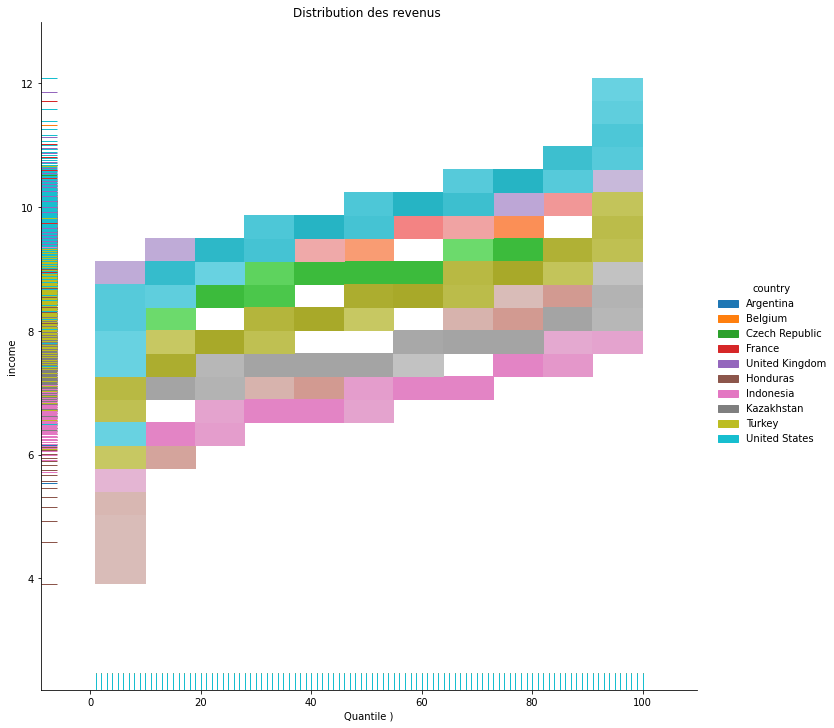

In [55]:
# Affichage de la distribution des revenus en fonction de la classe de revenus
sns.displot(x='quantile', y='incomelog', hue='country', rug=True, height=10, data=df5)
plt.title('Distribution des revenus ')
plt.xlabel('Quantile )')
plt.ylabel('income')
plt.show()


In [56]:
df5.country_code.unique()

array(['ARG', 'BEL', 'CZE', 'FRA', 'GBR', 'HND', 'IDN', 'KAZ', 'TUR',
       'USA'], dtype=object)

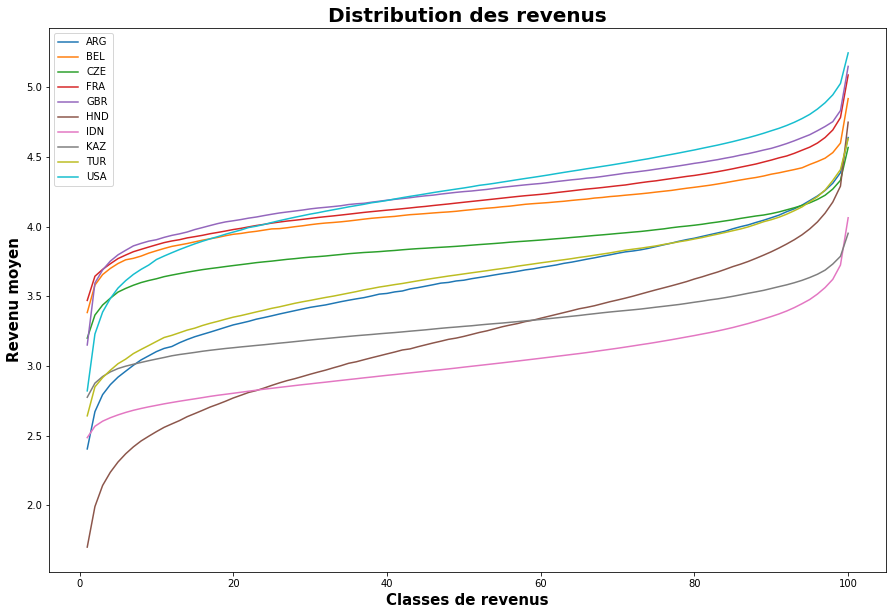

In [57]:
code_lorenz= ['ARG', 'BEL', 'CZE', 'FRA', 'GBR', 'HND', 'IDN', 'KAZ', 'TUR','USA']

plt.figure(figsize=(15,10))
for x in code_lorenz: 
    data = df5[df5.country_code == x]
    plt.plot(data['quantile'], np.log10(data['income']), label=x)
    
    
plt.title("Distribution des revenus", fontsize=20, fontweight='bold')
plt.xlabel("Classes de revenus", fontsize=15, fontweight='bold')
plt.ylabel("Revenu moyen", fontsize=15, fontweight='bold')
plt.legend()


In [58]:
gini=pd.read_csv("gini.csv", skiprows=4).reset_index()
gini.head()

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Africa Western and Central,AFW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Angola,AGO,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN


In [59]:
gini2=gini[['index','Country Name','Country Code','Indicator Name','Indicator Code','2004','2006','2007','2008','2009','2010','2011']]

In [60]:
gini3=gini2.copy()

In [61]:
gini3.rename(columns={'Country Code':'country_code', 'Country Name':'country'}, inplace=True)

In [62]:
gini3.dropna(inplace=True)

In [63]:
gini3.head(10)

,index,country,country_code,Indicator Name,Indicator Code,2004,2006,2007,2008,2009,2010,2011
9,9,Argentina,ARG,Gini index (World Bank estimate),SI.POV.GINI,48.4,46.3,46.2,44.9,43.7,43.6,42.6
10,10,Armenia,ARM,Gini index (World Bank estimate),SI.POV.GINI,37.5,29.7,31.2,29.2,28.0,30.0,29.4
14,14,Austria,AUT,Gini index (World Bank estimate),SI.POV.GINI,29.8,29.6,30.6,30.4,31.5,30.3,30.8
17,17,Belgium,BEL,Gini index (World Bank estimate),SI.POV.GINI,30.5,28.1,29.2,28.4,28.6,28.4,28.1
25,25,Belarus,BLR,Gini index (World Bank estimate),SI.POV.GINI,26.5,28.3,29.6,27.8,27.7,28.6,27.2
48,48,Costa Rica,CRI,Gini index (World Bank estimate),SI.POV.GINI,48.3,49.4,49.3,48.6,50.6,48.2,48.7
53,53,Cyprus,CYP,Gini index (World Bank estimate),SI.POV.GINI,30.1,31.1,31.1,31.7,32.1,31.5,32.6
54,54,Czech Republic,CZE,Gini index (World Bank estimate),SI.POV.GINI,27.5,26.7,26.0,26.3,26.2,26.6,26.4
55,55,Germany,DEU,Gini index (World Bank estimate),SI.POV.GINI,30.4,31.3,31.3,31.1,30.5,30.2,30.5
58,58,Denmark,DNK,Gini index (World Bank estimate),SI.POV.GINI,24.9,25.9,26.2,25.2,26.7,27.2,27.3


In [64]:
gini10pays=gini3.set_index('country_code')


In [65]:
gini10pays

,index,country,Indicator Name,Indicator Code,2004,2006,2007,2008,2009,2010,2011
country_code,,,,,,,,,,,
ARG,9,Argentina,Gini index (World Bank estimate),SI.POV.GINI,48.4,46.3,46.2,44.9,43.7,43.6,42.6
ARM,10,Armenia,Gini index (World Bank estimate),SI.POV.GINI,37.5,29.7,31.2,29.2,28.0,30.0,29.4
AUT,14,Austria,Gini index (World Bank estimate),SI.POV.GINI,29.8,29.6,30.6,30.4,31.5,30.3,30.8
BEL,17,Belgium,Gini index (World Bank estimate),SI.POV.GINI,30.5,28.1,29.2,28.4,28.6,28.4,28.1
BLR,25,Belarus,Gini index (World Bank estimate),SI.POV.GINI,26.5,28.3,29.6,27.8,27.7,28.6,27.2
CRI,48,Costa Rica,Gini index (World Bank estimate),SI.POV.GINI,48.3,49.4,49.3,48.6,50.6,48.2,48.7
CYP,53,Cyprus,Gini index (World Bank estimate),SI.POV.GINI,30.1,31.1,31.1,31.7,32.1,31.5,32.6
CZE,54,Czech Republic,Gini index (World Bank estimate),SI.POV.GINI,27.5,26.7,26.0,26.3,26.2,26.6,26.4
DEU,55,Germany,Gini index (World Bank estimate),SI.POV.GINI,30.4,31.3,31.3,31.1,30.5,30.2,30.5


In [66]:
gini10pays=gini10pays.loc(axis=0)['IDN','HND', 'TUR', 'USA', 'BEL', 'FRA', 'ARG', 'KAZ','GBR','CZE']

In [67]:
gini10pays = gini10pays[['2004', '2006', '2007', '2008', '2009', '2010','2011']]
gini10pays

,2004,2006,2007,2008,2009,2010,2011
country_code,,,,,,,
IDN,32.7,34.3,35.7,35.2,35.1,36.4,39.7
HND,58.1,57.5,55.8,55.5,51.3,53.1,52.6
TUR,41.3,39.6,38.4,39.0,39.0,38.8,40.0
USA,40.3,41.4,40.8,40.8,40.6,40.0,40.9
BEL,30.5,28.1,29.2,28.4,28.6,28.4,28.1
FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
ARG,48.4,46.3,46.2,44.9,43.7,43.6,42.6
KAZ,31.8,30.2,30.1,28.5,28.2,28.0,28.0
GBR,36.0,34.6,35.7,34.1,34.3,34.4,33.2


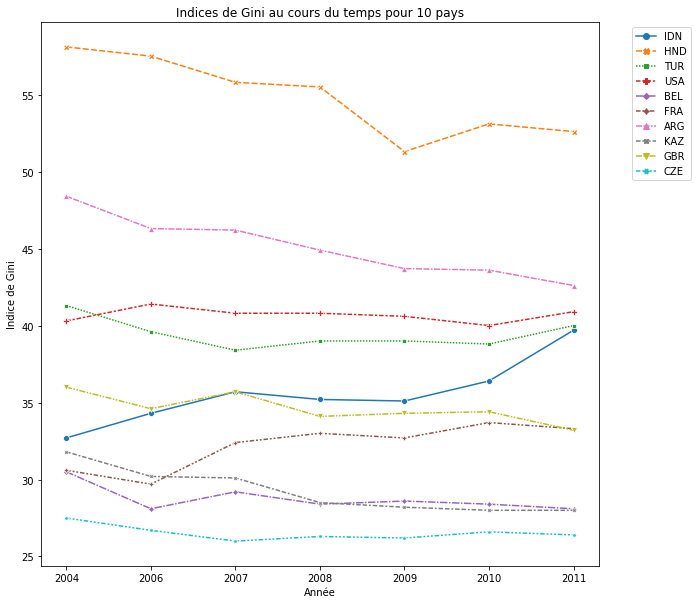

In [68]:
#T pour transpose

gini_T=gini10pays.T

plt.figure(figsize=(10,10))
sns.lineplot(data=gini_T, markers=True)
plt.title('Indices de Gini au cours du temps pour 10 pays')
plt.xlabel('Année')
plt.ylabel('Indice de Gini')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [69]:
#5 pays ayant l'indice de gini le plus faible
#Que peut on en deduire ?
gini_T.describe()

country_code,IDN,HND,TUR,USA,BEL,FRA,ARG,KAZ,GBR,CZE
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000,7.000000
mean,35.585714,54.842857,39.442857,40.685714,28.757143,32.20000,45.100000,29.257143,34.614286,26.528571
std,2.159034,2.570251,0.972723,0.448808,0.854122,1.48324,2.001666,1.467262,0.958173,0.488925
min,32.700000,51.300000,38.400000,40.000000,28.100000,29.70000,42.600000,28.000000,33.200000,26.000000
25%,34.700000,52.850000,38.900000,40.450000,28.250000,31.50000,43.650000,28.100000,34.200000,26.250000
50%,35.200000,55.500000,39.000000,40.800000,28.400000,32.70000,44.900000,28.500000,34.400000,26.400000
75%,36.050000,56.650000,39.800000,40.850000,28.900000,33.15000,46.250000,30.150000,35.150000,26.650000
max,39.700000,58.100000,41.300000,41.400000,30.500000,33.70000,48.400000,31.800000,36.000000,27.500000


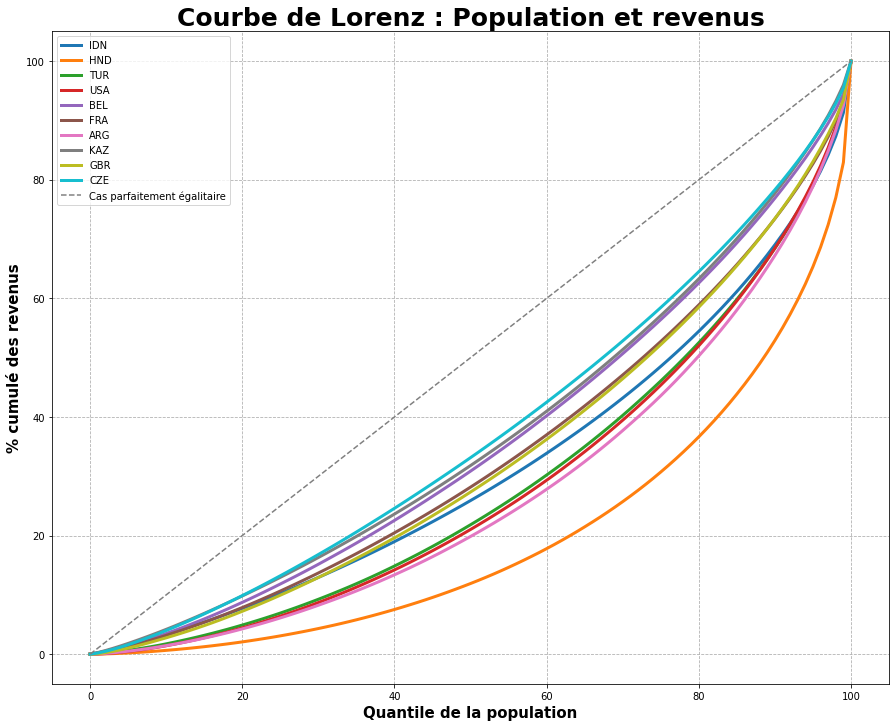

In [70]:
code_lorenz= ['IDN','HND', 'TUR', 'USA', 'BEL', 'FRA', 'ARG', 'KAZ','GBR','CZE']

#for i in code_lorenz:
 # arr = df4.loc[df4['country_code'] == i]['income']
  #X = np.array(arr)
  #lorenz_curve(X)

#Courbe de Lorenz
plt.figure(figsize = (15, 12))
list_gini = []

for count in code_lorenz:
    # revenus_total_pays : Revenus total sur les 100 centiles
    revenus_total_pays = df5[df5.country_code==count]['income'].sum()
    
    dep = df5[df5.country==count]['income'].values
    n = len(dep)
    
    # lorenz : Courbe de lorenz
    lorenz = (np.cumsum(np.sort(df5[df5.country_code==count]['income']))/revenus_total_pays)*100
    lorenz = np.append([0],lorenz) 
    x = np.append([0],df4[df4.country_code==count]['quantile'])    
    plt.plot(x,lorenz,linewidth=3, label=count)

    
plt.plot([0,100],[0,100],'grey',linestyle='--',linewidth=1.5, label='Cas parfaitement égalitaire')
plt.xlabel('Quantile de la population',fontsize=15,fontweight = 'bold')
plt.ylabel('% cumulé des revenus',fontsize=15,fontweight = 'bold')
plt.legend(loc='upper left',fontsize=10)
plt.grid(True,linestyle='--')
plt.title('Courbe de Lorenz : Population et revenus',fontsize=25,fontweight = 'bold')


plt.show()


In [71]:
#Methode melt 
#Annulez le pivotement d'un DataFrame du format large au format long, en laissant éventuellement les identifiants définis.
gini = pd.melt(gini, id_vars =['Country Code', 'Country Name'], value_vars = ('2004', '2006', '2007', '2008', '2009', '2010', '2011'), var_name ='year', 
                    value_name ='gini')
gini.rename(columns={'Country Code':'country_code', 'Country Name':'country'}, inplace=True)
gini['gini'] = round(gini['gini']/100, 2)
gini.dropna(inplace=True)
gini['year'] = gini['year'].astype(int)
gini

,country_code,country,year,gini
9,ARG,Argentina,2004,0.48
10,ARM,Armenia,2004,0.38
13,AUS,Australia,2004,0.33
14,AUT,Austria,2004,0.30
15,AZE,Azerbaijan,2004,0.27
...,...,...,...,...
1844,UKR,Ukraine,2011,0.25
1846,URY,Uruguay,2011,0.42
1847,USA,United States,2011,0.41
1857,XKX,Kosovo,2011,0.28


In [72]:
#Jointure
df4=pd.merge(df4,gini,how='left',on=['year','country','country_code'])
df4

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0,0.30
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0,0.30
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0,0.30
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0,0.30
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0,0.30
...,...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,NaN
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,NaN
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,NaN
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,NaN


In [73]:
print( str(df5.isna().sum()) + '\n')

country_code    0
country         0
year            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
population      0
incomelog       0
dtype: int64



In [74]:
pays_def=df4[df4['gini'].isna()][['country_code', 'country', 'year']]


In [75]:
#Le nombre de pays sans indice de gini
pays_def.country_code.unique()

array(['AZE', 'CAF', 'CAN', 'CHN', 'CIV', 'EGY', 'GHA', 'GTM', 'HRV',
       'IND', 'IRN', 'IRQ', 'ISR', 'KEN', 'KGZ', 'KHM', 'KOR', 'XKX',
       'LAO', 'LKA', 'MAR', 'MDA', 'MKD', 'MLI', 'MNE', 'MYS', 'NGA',
       'PAK', 'SRB', 'SVK', 'SWZ', 'SYR', 'TWN', 'TZA', 'VEN', 'PSE',
       'YEM', 'COD'], dtype=object)

In [76]:
pays_def = df4[df4.isna().any(axis=1)].drop_duplicates(subset=['country_code', 'quantile', 'year'])
pays_def


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
400,AZE,Azerbaijan,2008,1,100,397.53983,8101.00000,8821873.0,NaN
401,AZE,Azerbaijan,2008,2,100,597.77320,8101.00000,8821873.0,NaN
402,AZE,Azerbaijan,2008,3,100,705.47003,8101.00000,8821873.0,NaN
403,AZE,Azerbaijan,2008,4,100,785.52610,8101.00000,8821873.0,NaN
404,AZE,Azerbaijan,2008,5,100,841.75244,8101.00000,8821873.0,NaN
...,...,...,...,...,...,...,...,...,...
11594,COD,The Democratic Republic Of The Congo,2008,96,100,810.62330,303.19305,4011486.0,NaN
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,NaN
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,NaN
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,NaN


In [77]:
#Calcule des indics de gini


liste= []
for code in pays_def['country_code']:
    dep = pays_def[pays_def['country_code']== code]['income'].values
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = (2*S)
    liste.append(gini)

In [78]:
integer = pays_def.copy()
integer.loc[:,'gini'] = liste
integer

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
400,AZE,Azerbaijan,2008,1,100,397.53983,8101.00000,8821873.0,0.312338
401,AZE,Azerbaijan,2008,2,100,597.77320,8101.00000,8821873.0,0.312338
402,AZE,Azerbaijan,2008,3,100,705.47003,8101.00000,8821873.0,0.312338
403,AZE,Azerbaijan,2008,4,100,785.52610,8101.00000,8821873.0,0.312338
404,AZE,Azerbaijan,2008,5,100,841.75244,8101.00000,8821873.0,0.312338
...,...,...,...,...,...,...,...,...,...
11594,COD,The Democratic Republic Of The Congo,2008,96,100,810.62330,303.19305,4011486.0,0.444008
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.444008
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.444008
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.444008


In [79]:
#Intégration finale  dans le dataframe original
for code in list(integer['country_code'].unique()) :
    df4.loc[df4['country_code'] == code,'gini'] = (integer.loc[integer['country_code'] == code,'gini'])
    

In [80]:
#Position de la France 
position = pd.DataFrame(df4.groupby(['country_code', 'country']).gini.mean()).reset_index()
position['rang'] = position['gini'].rank(ascending=True)
position.head()

,country_code,country,gini,rang
0,ALB,Albania,0.300000,20.5
1,ARG,Argentina,0.450000,92.5
2,ARM,Armenia,0.290000,15.5
3,AUT,Austria,0.300000,20.5
4,AZE,Azerbaijan,0.312338,27.0


In [81]:
position[position.country=='France']

,country_code,country,gini,rang
34,FRA,France,0.33,37.0


# Mission3

In [82]:
coeff_elas=pd.read_csv("elasticity.csv")

In [83]:
coeff_elas

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,cohort,parent,child,obs,P1,P2,P3,P4,P5,C1,C2,C3,C4,C5,MEANp,MEANc,SDp,SDc,GINIp,GINIc,IGP,NL1,NL2,COR,MAcatM,MAcatC1,Q4_IGpri,BHQ1,BHQ2,BHQ3,BHQ4,Q4BH,Q4child,Delta50,Asher_Q4_IGpri,ThreeGen_obs,ThreeGen_IGPp1,ThreeGen_IGPg1,ThreeGen_IGPgsd,All2125_MEANp,All2125_MEANc,All2125_IGP,All2125_MAcatC1,Cores2125_MEANp,Cores2125_MEANc,Cores2125_IGP,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,avg,all,3956.0,0.666125,0.098583,0.170931,0.043031,0.021330,0.511857,0.025805,0.164191,0.183469,0.114678,2.480162,5.582401,3.809782,5.857765,0.728547,0.569981,0.802107,1.078013,-0.025322,0.521676,0.416691,0.414355,0.573748,0.341912,0.325161,0.209395,0.123532,0.162255,0.250311,3.408008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.10
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,avg,daughter,721.0,0.615321,0.099272,0.212776,0.051969,0.020662,0.628481,0.023378,0.099265,0.132322,0.116553,2.989992,4.331731,4.010379,5.902685,0.675526,0.681604,0.848156,0.904866,-0.005200,0.576251,0.284895,0.283075,0.493111,0.434127,0.390918,0.101283,0.073671,0.285185,0.214735,1.859528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.10
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,avg,son,3235.0,0.678699,0.098412,0.160574,0.040819,0.021495,0.482992,0.026405,0.180261,0.196128,0.114214,2.353979,5.891941,3.748495,5.806141,0.741541,0.541870,0.807674,1.168599,-0.033091,0.521442,0.449310,0.446874,0.599971,0.322116,0.311027,0.232628,0.134229,0.122268,0.259117,3.740587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.10
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,dad,all,4137.0,0.686581,0.047610,0.057309,0.150907,0.057594,0.514562,0.026047,0.165638,0.181551,0.112202,3.756049,5.538275,5.493762,5.842035,0.713742,0.572566,0.514428,0.578723,-0.004792,0.483760,0.354333,0.350244,0.548029,0.334443,0.317131,0.219586,0.128840,0.192434,0.250295,3.538447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.10
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,dad,daughter,744.0,0.639092,0.052328,0.054086,0.190100,0.064394,0.630354,0.022781,0.103736,0.129553,0.113576,4.520877,4.277768,5.804775,5.869737,0.660039,0.684751,0.491792,0.553255,-0.004494,0.486349,0.235170,0.230126,0.454504,0.429996,0.385429,0.104363,0.080212,0.339629,0.212542,1.974941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,1980,max,daughter,1192.0,0.193782,0.273000,0.278278,0.138380,0.058767,0.519847,0.122754,0.147193,0.171519,0.020772,8.790254,5.346238,3.850706,5.218582,0.240446,0.536002,0.437543,-0.072278,0.028631,0.322856,0.211980,0.204545,0.525806,0.304184,0.315410,0.294525,0.085881,0.309017,0.233044,-1.947602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1830.0,0.023843,980.0,0.069934,NaN,NaN,NaN,NaN,0.16
6500,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,1980,max,son,1404.0,0.237626,0.249623,0.282923,0.121555,0.047556,0.502914,0.109372,0.138117,0.22

In [84]:
coeff_elas.region.unique()

array(['South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia',
       'Latin America & Caribbean', 'High income', 'East Asia & Pacific',
       'Middle East & North Africa'], dtype=object)

In [85]:
coeff_elas.rename(columns={'countryname': 'country', 'iso3' : 'country_code'}, inplace=True)

In [86]:
coeff_elas=coeff_elas[['country','country_code','region','IGEincome']]

In [87]:
coeff_elas1=coeff_elas.copy()
coeff_elas1.drop_duplicates(inplace=True)
coeff_elas1.drop_duplicates(subset=['country'], keep = 'last', inplace=True)
coeff_elas1

,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
12,Angola,AGO,Sub-Saharan Africa,NaN
60,Albania,ALB,Europe & Central Asia,0.815874
84,Argentina,ARG,Latin America & Caribbean,NaN
99,Armenia,ARM,Europe & Central Asia,NaN
...,...,...,...,...
6378,West Bank and Gaza,PSE,Middle East & North Africa,NaN
6390,"Yemen, Rep.",YEM,Middle East & North Africa,NaN
6426,South Africa,ZAF,Sub-Saharan Africa,0.677000
6480,"Congo, Dem. Rep.",COD,Sub-Saharan Africa,0.707703


In [88]:
pays_vide=coeff_elas1[coeff_elas1['IGEincome'].isna()]

In [89]:
dtf_elas = pays_vide['country_code'].unique()
dtf_elas

array(['AFG', 'AGO', 'ARG', 'ARM', 'AZE', 'BFA', 'BGD', 'BGR', 'BTN',
       'BWA', 'CAF', 'CIV', 'CMR', 'COG', 'COM', 'CPV', 'CRI', 'DJI',
       'DOM', 'EST', 'FJI', 'GAB', 'GEO', 'GNB', 'HND', 'HUN', 'IDN',
       'IRN', 'IRQ', 'ISL', 'ISR', 'KHM', 'KIR', 'KSV', 'LAO', 'LBN',
       'LBR', 'LKA', 'LSO', 'LTU', 'MDA', 'MDV', 'MEX', 'MNE', 'MOZ',
       'MRT', 'MUS', 'MYS', 'NAM', 'NER', 'NIC', 'PHL', 'PNG', 'POL',
       'PRY', 'SDN', 'SEN', 'SLE', 'SLV', 'SRB', 'SSD', 'STP', 'SWZ',
       'TCD', 'TGO', 'THA', 'TJK', 'TON', 'TUR', 'TUV', 'UKR', 'URY',
       'VEN', 'VUT', 'PSE', 'YEM', 'ZMB'], dtype=object)

In [90]:
for i in dtf_elas:
    if list(coeff_elas1.loc[coeff_elas1['country_code'] == i, 'region']) == ['South Asia']:
        coeff_elas1.loc[coeff_elas1['country_code'] == i, 'IGEincome'] = 0.6
    elif list(coeff_elas1.loc[coeff_elas1['country_code'] == i, 'region']) == ['Sub-Saharan Africa']:
        coeff_elas1.loc[coeff_elas1['country_code'] == i, 'IGEincome'] = 0.66
    elif list(coeff_elas1.loc[coeff_elas1['country_code'] == i, 'region']) == ['Latin America & Caribbean']:
        coeff_elas1.loc[coeff_elas1['country_code'] == i, 'IGEincome'] = 0.66
    elif list(coeff_elas1.loc[coeff_elas1['country_code'] == i, 'region']) == ['Europe & Central Asia']:
        coeff_elas1.loc[coeff_elas1['country_code'] == i, 'IGEincome'] = 0.4                                                               
    elif list(coeff_elas1.loc[coeff_elas['country_code'] == i, 'region']) == ['East Asia & Pacific']:
        coeff_elas1.loc[coeff_elas1['country_code'] == i, 'IGEincome'] = 0.66
    elif list(coeff_elas1.loc[coeff_elas1['country_code'] == i, 'region']) == ['High Income']:
        coeff_elas1.loc[coeff_elas1['country_code'] == i, 'IGEincome'] = 0.4
    elif list(coeff_elas1.loc[coeff_elas1['country_code'] == i, 'region']) == ['Middle East & North Africa']:
        coeff_elas1.loc[coeff_elas1['country_code'] == i, 'IGEincome'] = 0.6
    else : coeff_elas1.loc[coeff_elas1['country_code'] == i, 'IGEincome'] =  0.40  

In [91]:
coeff_elas1

,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,0.600000
12,Angola,AGO,Sub-Saharan Africa,0.660000
60,Albania,ALB,Europe & Central Asia,0.815874
84,Argentina,ARG,Latin America & Caribbean,0.660000
99,Armenia,ARM,Europe & Central Asia,0.400000
...,...,...,...,...
6378,West Bank and Gaza,PSE,Middle East & North Africa,0.600000
6390,"Yemen, Rep.",YEM,Middle East & North Africa,0.600000
6426,South Africa,ZAF,Sub-Saharan Africa,0.677000
6480,"Congo, Dem. Rep.",COD,Sub-Saharan Africa,0.707703


In [92]:
df_revenu_general = pd.merge(df4,coeff_elas1[['country_code', 'IGEincome']],how='left', on='country_code')
df_revenu_general.rename(columns={'IGEincome': 'pj'}, inplace=True)
df_revenu_general


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,pj
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0,0.300000,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0,0.300000,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0,0.300000,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0,0.300000,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0,0.300000,0.815874
...,...,...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.444008,0.707703
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.444008,0.707703
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.444008,0.707703
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,0.444008,0.707703


In [93]:
df_revenu_general['pj']=df_revenu_general['pj'].fillna(0.4)

In [94]:
#Pour l'élasticité de la france #0.32
pjf=0.32
nb_quantiles=10
n=1000*nb_quantiles


In [95]:
#Revenue des enfants ychild
y_child, y_parents=generate_incomes(n, pjf)

In [96]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)

In [97]:
sample

,y_child,y_parents,c_i_child,c_i_parent
0,2.102649,0.479606,8,3
1,0.120495,0.223158,1,1
2,0.212088,1.124450,1,6
3,0.585641,1.448690,4,7
4,0.559991,0.369236,3,2
...,...,...,...,...
9995,1.659862,1.560978,7,7
9996,2.312232,2.115844,8,8
9997,2.666797,0.340898,9,2
9998,2.083759,0.779947,8,5


In [98]:
cd=conditional_distributions(sample, nb_quantiles)

In [99]:
for i in range(len(sample)):
    c_i_child=(sample.loc[i,"c_i_child"])
    c_i_parent=(sample.loc[i,"c_i_parent"])
    p = proba_cond(c_i_parent-1,c_i_child-1, cd)

In [100]:
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pjf, p))


P(c_i_parent = 6 | c_i_child = 4, pj = 0.32) = 0.1


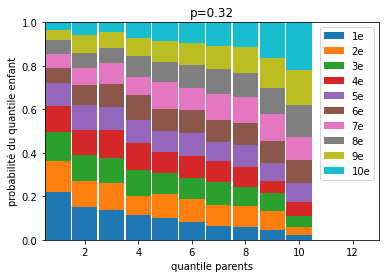

In [101]:
plot_conditional_distributions(pjf, cd, nb_quantiles)

In [102]:


pj=0.9
nb_quantiles=10
n= 1000* nb_quantiles



In [103]:
#Revenue des enfants ychild
y_child, y_parents=generate_incomes(n, pj)

In [104]:
#calcule des classe de revenu des enfants selon n


In [105]:
y_child

array([1.56185972, 0.44074499, 1.89868502, ..., 0.43592354, 0.40486841,
       1.56071374])

In [106]:
y_parents

array([0.76713025, 0.98402645, 2.45860746, ..., 0.27809373, 0.3926299 ,
       1.18222665])

In [107]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)

In [108]:
sample

,y_child,y_parents,c_i_child,c_i_parent
0,1.561860,0.767130,7,4
1,0.440745,0.984026,3,5
2,1.898685,2.458607,7,9
3,0.210292,0.157459,2,1
4,5.716478,2.045312,10,8
...,...,...,...,...
9995,2.830281,4.981205,8,10
9996,0.604628,0.542074,4,3
9997,0.435924,0.278094,3,1
9998,0.404868,0.392630,3,2


In [109]:
#À partir de cette dernière information, estimez pour chaque  \(c_{i,child}\) la distribution conditionnelle de \(c_{i,parent}\)
cd=conditional_distributions(sample, nb_quantiles)


In [110]:
cd.shape

(10, 10)

In [111]:
cd

array([[0.451, 0.221, 0.145, 0.076, 0.052, 0.025, 0.016, 0.01 , 0.004,
        0.   ],
       [0.237, 0.198, 0.184, 0.121, 0.102, 0.06 , 0.051, 0.03 , 0.014,
        0.003],
       [0.14 , 0.168, 0.151, 0.145, 0.115, 0.106, 0.078, 0.059, 0.031,
        0.007],
       [0.073, 0.125, 0.121, 0.163, 0.143, 0.125, 0.099, 0.087, 0.043,
        0.021],
       [0.044, 0.081, 0.136, 0.124, 0.139, 0.123, 0.123, 0.126, 0.064,
        0.04 ],
       [0.027, 0.092, 0.116, 0.121, 0.13 , 0.131, 0.119, 0.112, 0.085,
        0.067],
       [0.02 , 0.056, 0.063, 0.101, 0.109, 0.132, 0.163, 0.117, 0.143,
        0.096],
       [0.008, 0.031, 0.054, 0.078, 0.103, 0.126, 0.149, 0.15 , 0.172,
        0.129],
       [0.   , 0.022, 0.025, 0.053, 0.072, 0.108, 0.121, 0.172, 0.223,
        0.204],
       [0.   , 0.006, 0.005, 0.018, 0.035, 0.064, 0.081, 0.137, 0.221,
        0.433]])

In [112]:
for i in range(len(sample)):
    c_i_child=(sample.loc[i,"c_i_child"])
    c_i_parent=(sample.loc[i,"c_i_parent"])
    p = proba_cond(c_i_parent-1,c_i_child-1, cd)



In [113]:
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))


P(c_i_parent = 6 | c_i_child = 7, pj = 0.9) = 0.132


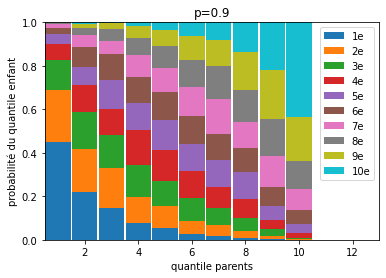

In [114]:
#Faible mobilité
plot_conditional_distributions(pj, cd, nb_quantiles)

In [115]:
#Graphique pour une forte mobilité

pj1 = 0.1
y_child1, y_parent1 = generate_incomes(n, pj1)
sample1 = compute_quantiles(y_child1, y_parent1, nb_quantiles)
cd1 = conditional_distributions(sample1, nb_quantiles)
cd1

array([[0.157, 0.11 , 0.107, 0.106, 0.109, 0.085, 0.088, 0.093, 0.082,
        0.063],
       [0.112, 0.098, 0.124, 0.094, 0.114, 0.113, 0.09 , 0.096, 0.094,
        0.065],
       [0.113, 0.107, 0.103, 0.107, 0.095, 0.105, 0.11 , 0.083, 0.092,
        0.085],
       [0.096, 0.107, 0.102, 0.108, 0.098, 0.098, 0.107, 0.101, 0.077,
        0.106],
       [0.088, 0.117, 0.093, 0.093, 0.095, 0.117, 0.109, 0.101, 0.084,
        0.103],
       [0.091, 0.099, 0.103, 0.101, 0.094, 0.098, 0.099, 0.103, 0.107,
        0.105],
       [0.092, 0.097, 0.102, 0.088, 0.091, 0.106, 0.099, 0.1  , 0.11 ,
        0.115],
       [0.086, 0.093, 0.095, 0.11 , 0.091, 0.1  , 0.094, 0.103, 0.121,
        0.107],
       [0.088, 0.101, 0.086, 0.092, 0.106, 0.095, 0.1  , 0.107, 0.118,
        0.107],
       [0.077, 0.071, 0.085, 0.101, 0.107, 0.083, 0.104, 0.113, 0.115,
        0.144]])

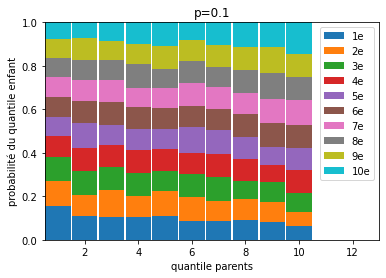

In [116]:
plot_conditional_distributions(pj1, cd1, nb_quantiles)

In [117]:
for i in range(len(sample1)):
    c_i_child=(sample1.loc[i,"c_i_child"])
    c_i_parent=(sample1.loc[i,"c_i_parent"])
    p = proba_cond(c_i_parent-1,c_i_child-1, cd1)


In [118]:
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj1, p))


P(c_i_parent = 10 | c_i_child = 6, pj = 0.1) = 0.105


In [119]:
#Clonage 500 clones echantillon

df500 = pd.concat([df_revenu_general] *500, ignore_index=True )
#df500.sort_values(by=['country', 'quantile'], inplace=True)
#df500.rename(columns={'quantile': 'c_i_child'}, inplace=True)


In [120]:
df500

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,pj
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0,0.300000,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0,0.300000,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0,0.300000,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0,0.300000,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0,0.300000,0.815874
...,...,...,...,...,...,...,...,...,...,...
5799995,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.444008,0.707703
5799996,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.444008,0.707703
5799997,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.444008,0.707703
5799998,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,0.444008,0.707703


In [121]:
# creation d'un variable quantile parents, à remplir
distriution_pays = []

In [122]:
df_ci= df500['country_code'].unique()

In [123]:
%%time
import time
start_time = time.time()

# creation d'un variable quantile parents, à remplir
distriution_pays = []
distriution_pays_list = []

#for iso3 in list_iso3 :
for i, code in enumerate(df_ci):
    print(f"""{time.time()-start_time:.2f}s - country {code} {i+1}/{len(df_ci)}""")
    # coeff d'elasticité pour chaque pays de
    pj = df500.loc[df500['country_code']== code,'pj'].iloc[0]  
    gini = df500.loc[df500['country_code']== code,'gini'].iloc[0]  
    country = df500.loc[df500['country_code']== code,'country'].iloc[0]
    
    nb_quantiles = 100 
    n =nb_quantiles*500 # taille de l'échantillon
    
    y_child, y_parents = generate_incomes(n, pj)                 # Génération de revenus selons une loi normale
    sample = compute_quantiles(y_child, y_parents, nb_quantiles) # Retourne un df avec income, y_parents, c_i_child, c_i_parents
    cd = conditional_distributions(sample, nb_quantiles)         # On compte chaque combinaison c_i_child, c_i_parent
    for c_i_child in range(100):
        income = df500.loc[((df500['country_code']== code) & (df500['quantile'] == c_i_child+1)),'income'].iloc[0]
        for c_i_parent in range(100):
            p = proba_cond(c_i_parent, c_i_child, cd)
            distriution_pays.extend([c_i_parent+1]*(int(p*500)))
            if (int(p*500)) :
                if country :
                    distriution_pays_list.extend([[country, code,  c_i_child+1, c_i_parent+1, income, gini, pj, p, int(p*500)]]*(int(p*500)))
                
            

0.00s - country ALB 1/116
34.44s - country ARG 2/116
68.86s - country ARM 3/116
103.44s - country AUT 4/116
137.92s - country AZE 5/116
172.31s - country BEL 6/116
207.09s - country BFA 7/116
241.28s - country BGD 8/116
276.06s - country BGR 9/116
310.31s - country BIH 10/116
344.61s - country BLR 11/116
379.14s - country BOL 12/116
413.44s - country BRA 13/116
448.28s - country BTN 14/116
482.80s - country CAF 15/116
517.14s - country CAN 16/116
551.62s - country CHL 17/116
585.82s - country CHN 18/116
620.17s - country CIV 19/116
654.45s - country CMR 20/116
688.74s - country COL 21/116
722.77s - country CRI 22/116
757.19s - country CYP 23/116
791.73s - country CZE 24/116
825.88s - country DEU 25/116
860.39s - country DNK 26/116
894.73s - country DOM 27/116
928.91s - country ECU 28/116
963.21s - country EGY 29/116
997.46s - country ESP 30/116
1032.06s - country EST 31/116
1066.67s - country FIN 32/116
1101.18s - country FJI 33/116
1135.34s - country FRA 34/116
1169.80s - country GBR 

In [124]:
distriution_501 = pd.DataFrame(distriution_pays_list,columns=['country','country_code', 'quantile', 'c_i_parent', 'income', 'gini', 'pj', 'p', 'p*500'])
display(distriution_501.shape)
distriution_501.head()

(5800000, 9)

,country,country_code,quantile,c_i_parent,income,gini,pj,p,p*500
0,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99
1,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99
2,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99
3,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99
4,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99


In [160]:
distriution_501.to_csv('df501', index=False)




# Mission4

In [125]:
import statsmodels.formula.api as smf

In [126]:
anova_income=smf.ols('income ~country_code', data=distriution_501).fit()
print(anova_income.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 4.971e+04
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:37:07   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799884   BIC:                         1.186e+08
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2994.8299    

In [127]:
#Seuil de la p-value<0.5 on rejette l'hypothe H0  donc les variables sont fortements corrélés

In [130]:
distriution_501['ln_income']=np.log(distriution_501['income'])

In [131]:
question_1=distriution_501.groupby(['country_code','quantile']).mean().reset_index()
question_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  11600 non-null  object 
 1   quantile      11600 non-null  int64  
 2   c_i_parent    11600 non-null  float64
 3   income        11600 non-null  float64
 4   gini          11600 non-null  float64
 5   pj            11600 non-null  float64
 6   p             11600 non-null  float64
 7   p*500         11600 non-null  float64
 8   ln_income     11600 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 815.8+ KB


In [132]:
anova_varieté = smf.ols('ln_income ~country_code', data=question_1).fit()
print(anova_varieté.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     269.0
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:38:46   Log-Likelihood:                -12627.
No. Observations:               11600   AIC:                         2.549e+04
Df Residuals:                   11484   BIC:                         2.634e+04
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.8517    

In [133]:
import statsmodels.api as sm
sm.stats.anova_lm(anova_varieté, typ=2)


,sum_sq,df,F,PR(>F)
country_code,16134.417851,115.0,268.95348,0.0
Residual,5990.615921,11484.0,NaN,NaN


In [134]:
df_income_avg = df3[['country_code','country','income']].groupby('country_code').mean().reset_index()
df_income_avg.rename(columns={'income':'income_avg'}, inplace=True)
distriution_501= distriution_501.merge(df_income_avg, how='left', on='country_code')
display(distriution_501.shape)
display(distriution_501.head())   

(5800000, 11)

,country,country_code,quantile,c_i_parent,income,gini,pj,p,p*500,ln_income,income_avg
0,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902
1,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902
2,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902
3,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902
4,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902


In [135]:
#Premier model

modele = smf.ols('income ~ gini + income_avg', data=distriution_501).fit()
print(modele.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 2.858e+06
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:39:55   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799997   BIC:                         1.186e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.583e-11     14.976   -4.4e-12      1.0

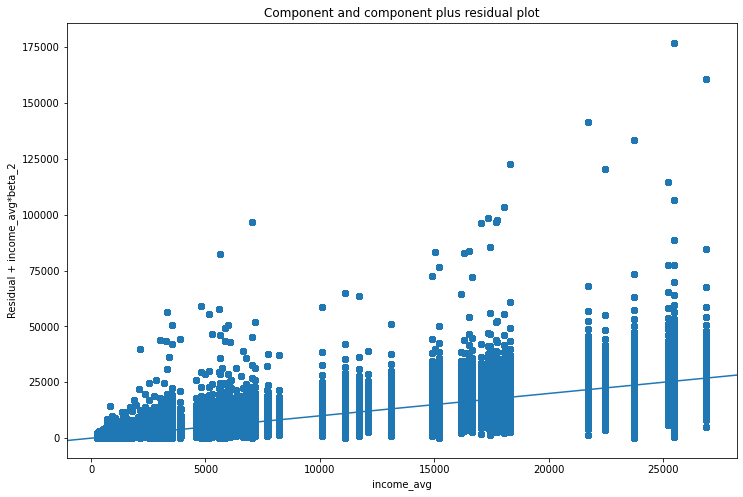

In [136]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(modele, "income_avg", ax=ax)

In [138]:
#Comparaison entre le modele 1 et le modele 2 logarithmique(revenu pays)
#logarithme du Revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu
distriution_501['log_income_avg']=np.log(distriution_501['income_avg'])
modele1 = smf.ols('ln_income ~ gini + log_income_avg', data=distriution_501).fit()
print(modele1.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 7.773e+06
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:41:38   Log-Likelihood:            -6.3237e+06
No. Observations:             5800000   AIC:                         1.265e+07
Df Residuals:                 5799997   BIC:                         1.265e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4745      0.003    163.

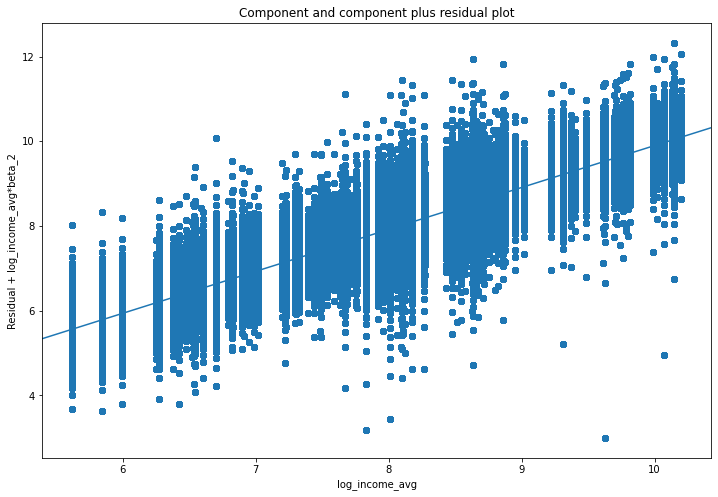

In [139]:
#Approche visuelle rapide de notre régression linéaire (cette fois-ci bien plus optimale)
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(modele1, "log_income_avg", ax=ax)

In [140]:
#73% de la variance est expliqué le modele 2 et plus performant que le modele 1 qui peut expliquer 50% de la variance

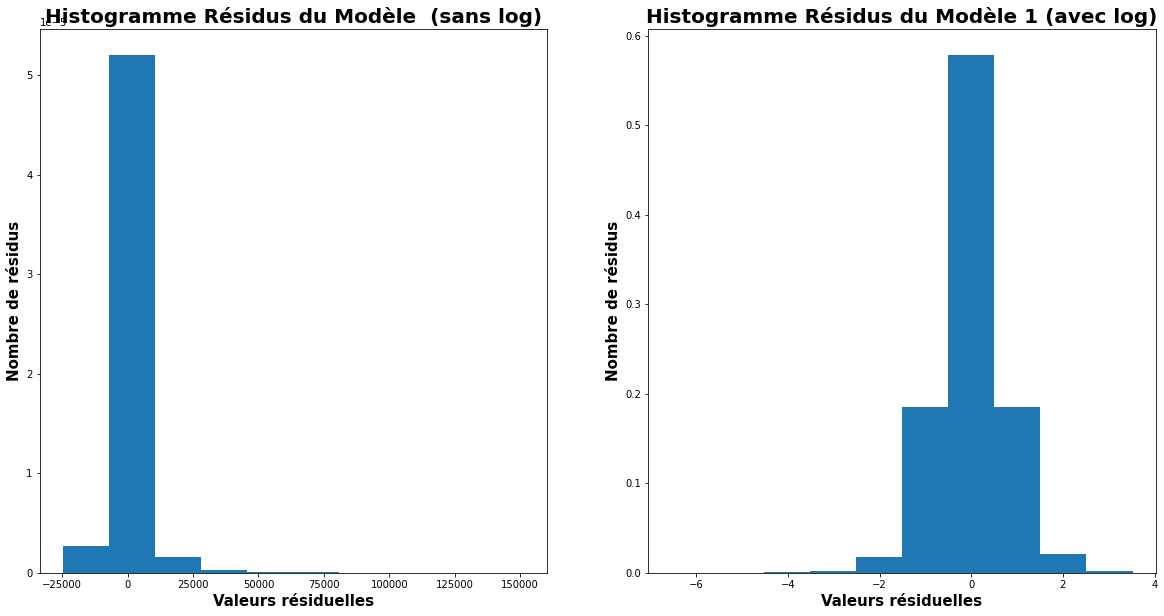

In [141]:
#Visualisation de la normalité des résidus : 
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.hist(modele.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme Résidus du Modèle  (sans log)', fontsize=20, fontweight='bold')

plt.subplot(122)
plt.hist(modele1.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme Résidus du Modèle 1 (avec log)', fontsize=20, fontweight='bold')


plt.show()

In [142]:
#Modele avec la variable c_i_parents
modele_parent = smf.ols('ln_income ~ gini + c_i_parent + log_income_avg', data=distriution_501).fit()
print(modele_parent.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                 6.902e+06
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:42:32   Log-Likelihood:            -5.6957e+06
No. Observations:             5800000   AIC:                         1.139e+07
Df Residuals:                 5799996   BIC:                         1.139e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0812      0.003    -30.

On peut constater  que le modele en incluant la variable c_i_parent et plus performant avec un R-squared=0.781.Il reste 22 % de la variance qui n'est pas expliqué .On peut conclure donc que ce sont des critère non traités

Text(0.5, 1.0, 'Histogramme Résidus du Modèle parent')

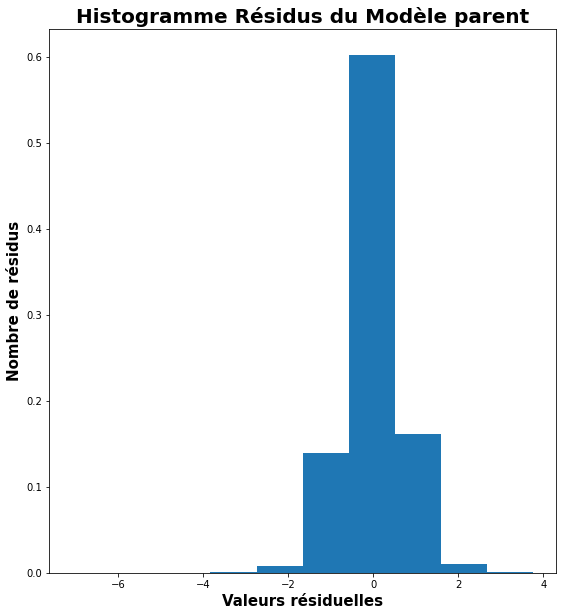

In [143]:
#Visualisation de la normalité des résidus : 
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.hist(modele_parent.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme Résidus du Modèle parent', fontsize=20, fontweight='bold')


In [161]:
from sklearn.metrics import pairwise_distances_argmin_min
from statsmodels.graphics.gofplots import ProbPlot

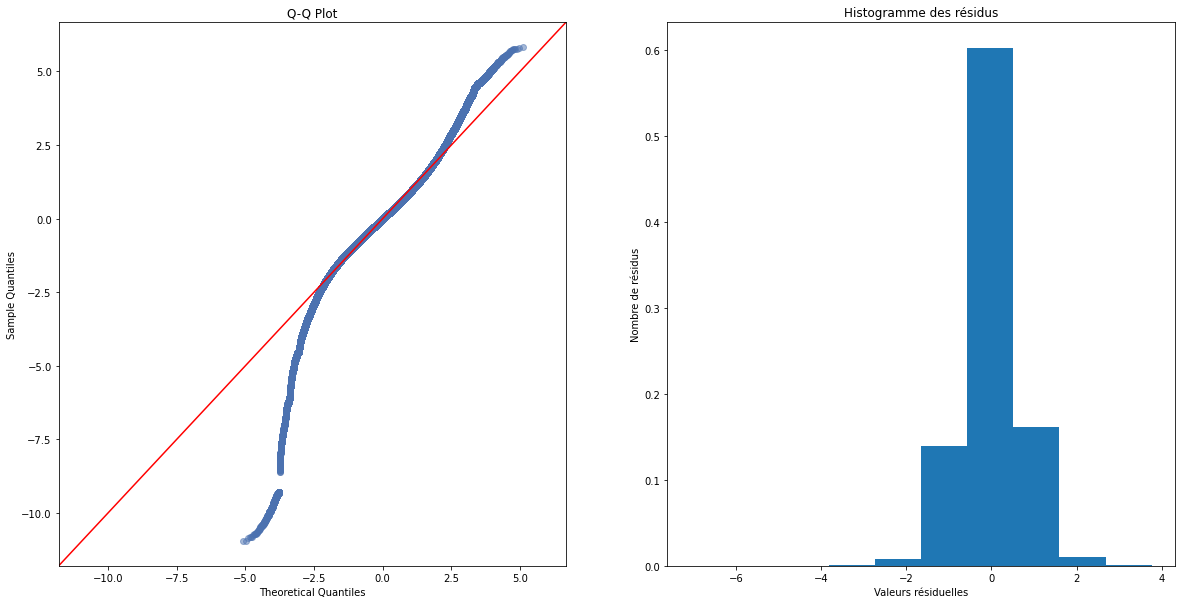

In [164]:
#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(20,10))

plt.hist(modele_parent.resid, density=True)

model_norm_residuals = modele_parent.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')
                

plt.show()

In [166]:
#Diagnostic
alpha = .05        #test niveau 5%
n = len(distriution_501) #nombre d'individus de l'échantillon
p = 4              #nombre de variables

#Nouveau dataframe d'étude du modèle 
diagnostic = distriution_501.copy()
diagnostic.head()

,country,country_code,quantile,c_i_parent,income,gini,pj,p,p*500,ln_income,income_avg,log_income_avg
0,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902,8.004643
1,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902,8.004643
2,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902,8.004643
3,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902,8.004643
4,Albania,ALB,1,1,728.89795,0.3,0.815874,0.198,99,6.591534,2994.829902,8.004643


In [ ]:
#@title ANALYSE DES LEVIERS SEUIL
#Analyse des leviers seuil

In [167]:
#Création de la variable levier
diagnostic['levier'] = modele_parent.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

In [168]:
#Agrégation des données selon leurs pays, vision simplifiée du couple pays/levier
#Simplification du dataframe pour une visualisation et interprétation plus rapide
diagnostic_levier = diagnostic.groupby('country').mean().reset_index()

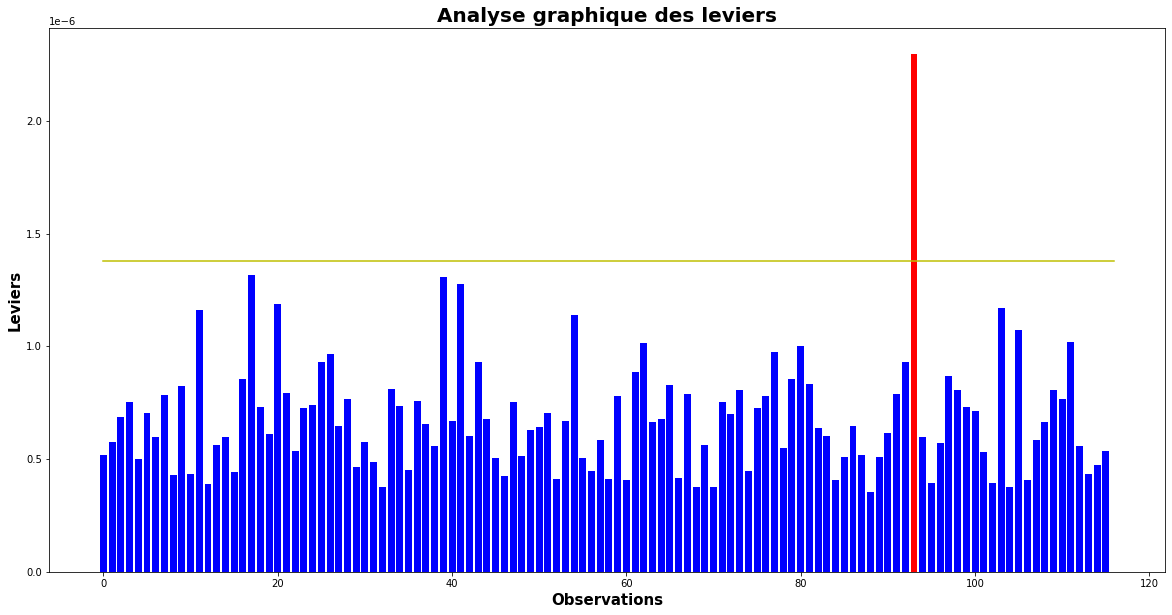

In [169]:
#Visualisation des leviers par pays avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(diagnostic_levier[diagnostic_levier['levier'] <= seuil_levier]['country'].index,
        diagnostic_levier[diagnostic_levier['levier'] <= seuil_levier]['levier'], color='b')
plt.bar(diagnostic_levier[diagnostic_levier['levier'] > seuil_levier]['country'].index,
        diagnostic_levier[diagnostic_levier['levier'] > seuil_levier]['levier'], color='r')
plt.plot([0, 116], [seuil_levier, seuil_levier], color='y')

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Leviers', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des leviers', fontsize=20, fontweight='bold')

plt.show()

In [170]:
#Identification du pays outlier sur le critère des leviers
diagnostic_levier[diagnostic_levier['levier'] > seuil_levier]['country']

93    South Africa
Name: country, dtype: object

ANALYSE DES RESIDUS STUDENTISES

In [172]:
#Intégration de la variable liée aux résidus
diagnostic['rstudent'] = modele_parent.get_influence().resid_studentized_internal

seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

In [173]:
#Agrégation des données selon leurs pays, vision simplifiée du couple pays-individu/rstudent
#Simplification du dataframe pour une visualisation et interprétation plus rapide
diagnostic_rstudent = diagnostic.groupby(['country', 'quantile']).mean().reset_index()

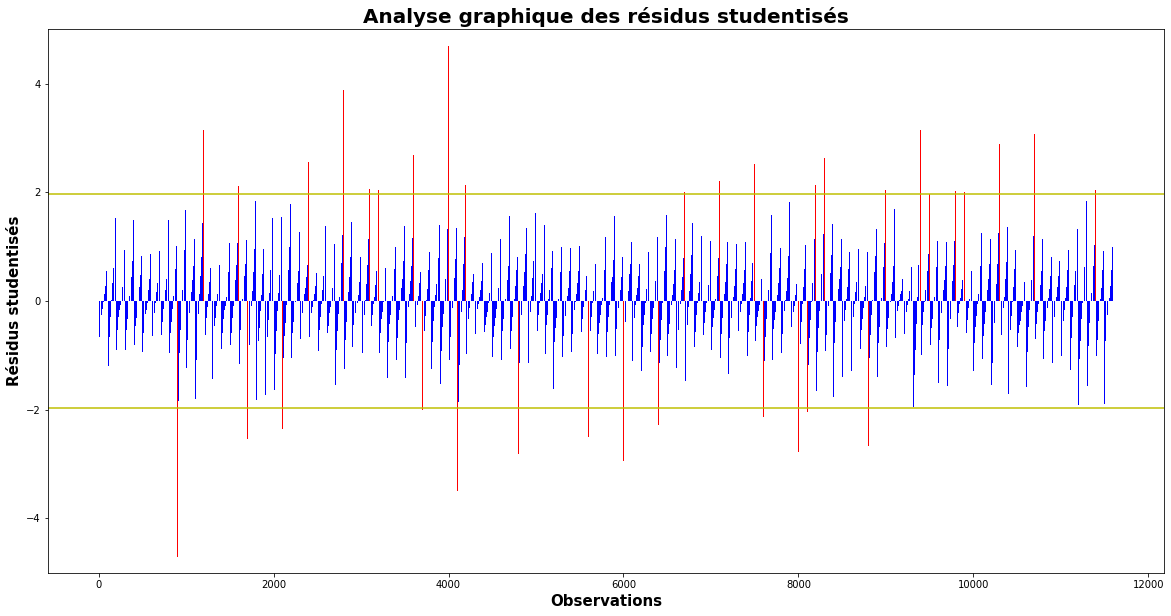

In [174]:
#Visualisation globale des résidus studentisés avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(diagnostic_rstudent[(diagnostic_rstudent['rstudent'] <= seuil_rstudent) & 
                            (diagnostic_rstudent['rstudent'] >= -seuil_rstudent)]['country'].index, 
        diagnostic_rstudent[(diagnostic_rstudent['rstudent'] <= seuil_rstudent) &
                            (diagnostic_rstudent['rstudent'] >= -seuil_rstudent)]['rstudent'], color='b')

plt.bar(diagnostic_rstudent[diagnostic_rstudent['rstudent'] > seuil_rstudent]['country'].index, 
        diagnostic_rstudent[diagnostic_rstudent['rstudent'] > seuil_rstudent]['rstudent'], color='r')
plt.bar(diagnostic_rstudent[diagnostic_rstudent['rstudent'] < -seuil_rstudent]['country'].index, 
        diagnostic_rstudent[diagnostic_rstudent['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

plt.axhline(y=seuil_rstudent, color='y', linestyle='-')
plt.axhline(y=-seuil_rstudent, color='y', linestyle='-')

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Résidus studentisés', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des résidus studentisés', fontsize=20, fontweight='bold')

plt.ylim(-5, 5)
plt.show()

In [175]:
#Pourcentage des observations hors seuil sur le critère des résidus standardisés
print(str(len(diagnostic_rstudent[(diagnostic_rstudent['rstudent'] > seuil_rstudent) | 
                 (diagnostic_rstudent['rstudent'] < -seuil_rstudent)])), 
                 'valeurs influentes dans le Modèle')
print('soit ' + str(round(477/len(diagnostic_rstudent), 2)*100) + '% valeurs plus influentes que les autres')

466 valeurs influentes dans le Modèle
soit 4.0% valeurs plus influentes que les autres


#deja identifier comme outliers, indice de gini trop élevé

In [144]:
#colinéarité
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [145]:
variables = modele_parent.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.065382725058378, 1.0, 1.0653827250581105]

In [146]:
#Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [147]:
#Tester l'homoscédacité (constance de la variances) des résidus
import statsmodels
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(modele_parent.resid, variables)
print('p value test Breusch Pagan:', pval)
 

p value test Breusch Pagan: 0.0


In [148]:
#La p-valeur ici est inférieur à  5 %, on  rejette  l'hypothèse  𝐻0  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

In [149]:
#NORMALITE des résidus
from scipy.stats import t, shapiro
shapiro(modele_parent.resid)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9798411726951599, 0.0)

In [151]:
#Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique,
#et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que
#les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

In [152]:
#DECOMPOSITION DES VARIABLES EXPLIQUEES
import statsmodels.api as sms
decomp_log = sms.stats.anova_lm(modele_parent, typ=2)
decomp_log 

,sum_sq,df,F,PR(>F)
gini,1.093905e+05,1.0,2.621086e+05,0.0
c_i_parent,5.852735e+05,1.0,1.402363e+06,0.0
log_income_avg,7.018663e+06,1.0,1.681728e+07,0.0
Residual,2.420618e+06,5799996.0,NaN,NaN


In [153]:
#SCT Somme des Carrés Totale 
decomp_log_sct = decomp_log.values[:,0].sum()
decomp_log_sct

10133944.383202048

In [154]:
#SCE Somme des Carrés Expliquée
decomp_log_sce = decomp_log.values[0,0]+decomp_log.values[1,0]+decomp_log.values[2,0]
decomp_log_sce

7713326.74651001

In [155]:
#SCR Somme des Carrés Résiduelle
decomp_log_scr = decomp_log.values[2,0]
decomp_log_scr

7018662.722480718

In [156]:
#R2 squared
decomp_log_r2 = decomp_log_sce/decomp_log_sct
decomp_log_r2

0.7611376631685056

In [157]:
#Variance expliquée par le revenu moyen du pays (ln_income_avg)
decomp_log_sce_incomeavg = sm.stats.anova_lm(modele_parent, typ=2).values[2,0]/decomp_log_sct
decomp_log_sce_incomeavg

0.6925894259016067

In [158]:
#Variance expliquée par l'indice de Gini
decomp_log_sce_gini = sm.stats.anova_lm(modele_parent, typ=2).values[0,0]/decomp_log_sct
decomp_log_sce_gini

0.010794468913492963

In [159]:
#Variance expliquée par la classe de revenu des parents
decomp_log_sce_pa = sm.stats.anova_lm(modele_parent, typ=2).values[1,0]/decomp_log_sct
decomp_log_sce_pa

0.057753768353406044

In [ ]:
#69% de la variance expliqué par le pays de l'individus
#1% de la variance éxpliqué par l'indice de gini
#5.7% de la varicance expliqué par la variable c-i-parent